## Toy Regression Problem

### Dependencies

In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import nuqls
from importlib import reload
import posteriors.swag as swag
# import posteriors.nuqls as post_nuqls

torch.set_default_dtype(torch.float64)

### Create toy data

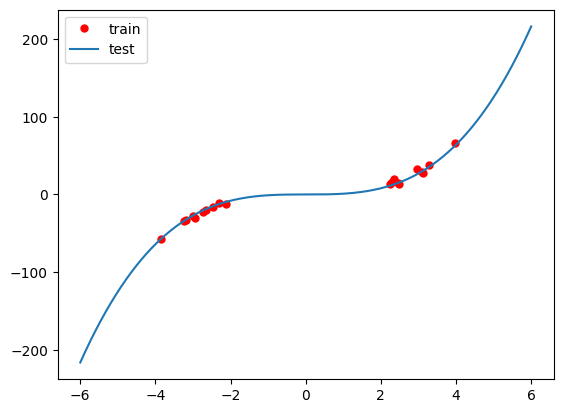

In [2]:
NUM_TRAIN_POINTS = 20
NUM_TEST_POINTS = 10000
std = 3
a1,a2,b1,b2 = -4,-2,2,4
c1,c2 = -6,6
eps = torch.randn((NUM_TRAIN_POINTS),1)*std
train_x = torch.cat((
    torch.rand((int(NUM_TRAIN_POINTS/2),1)) * (a2-a1) + a1,
    torch.rand((int(NUM_TRAIN_POINTS/2),1)) * (b2-b1) + b1
),dim=0)
train_y = torch.pow(train_x,3) + eps

train_y_std = train_y.std()
train_y_mean = train_y.mean()

test_x = torch.linspace(c1,c2,NUM_TEST_POINTS).reshape(-1,1)
test_y = torch.pow(test_x,3).reshape(-1,1)

## plot train
plt.plot(train_x.cpu().numpy().reshape(-1),train_y.cpu().numpy().reshape(-1),'ro',markersize=5,label='train')
plt.plot(test_x.cpu().numpy().reshape(-1),test_y.cpu().numpy().reshape(-1),label='test')
plt.legend()
plt.show()

In [3]:
class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
toy_train_loader = DataLoader(toy_dataset(train_x,train_y),NUM_TRAIN_POINTS)
toy_test_loader = DataLoader(toy_dataset(test_x,test_y),NUM_TEST_POINTS)

Using cpu device


  4%|▎         | 357/10000 [00:00<00:02, 3352.56it/s]

Train loss = 918.7331149506706


 14%|█▍        | 1391/10000 [00:00<00:02, 3285.18it/s]

Train loss = 90.82012735769283


 24%|██▍       | 2408/10000 [00:00<00:02, 3327.02it/s]

Train loss = 57.136168499344855


 35%|███▍      | 3462/10000 [00:01<00:01, 3350.22it/s]

Train loss = 29.3499545369148


 45%|████▍     | 4471/10000 [00:01<00:01, 3229.74it/s]

Train loss = 12.44180290628629


 55%|█████▌    | 5534/10000 [00:01<00:01, 3440.09it/s]

Train loss = 9.041647574725715


 63%|██████▎   | 6265/10000 [00:01<00:01, 3413.03it/s]

Train loss = 7.744650712308302


 74%|███████▎  | 7356/10000 [00:02<00:00, 3452.64it/s]

Train loss = 6.903636785676207


 84%|████████▍ | 8448/10000 [00:02<00:00, 3435.67it/s]

Train loss = 6.441369772704675


 96%|█████████▌| 9560/10000 [00:02<00:00, 3492.79it/s]

Train loss = 6.24811522932445


100%|██████████| 10000/10000 [00:02<00:00, 3393.59it/s]

Done!
Gradient norm : 0.1281


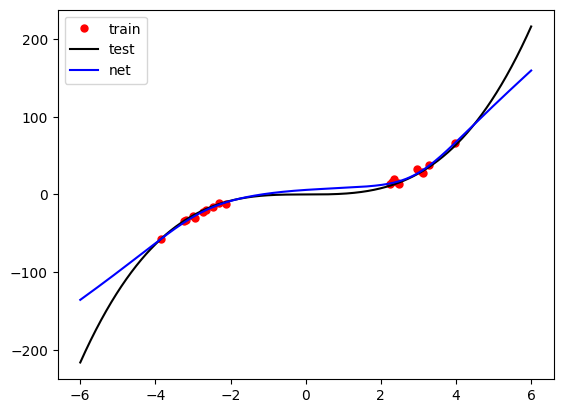

In [17]:
# Get cpu, gpu or mps device for training.
import utils.training


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

## Set up neural network.
width = 50

class oneLayerMLP(torch.nn.Module):
    def __init__(self, width):
        super().__init__()
        self.output_size = 1
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, width),
            torch.nn.SiLU(),
            torch.nn.Linear(width, 1)
        )

    def forward(self, x):
        output = self.net(x)
        return output
    

## MSE Model
map_net = oneLayerMLP(width).to(device)
map_net.apply(utils.training.weights_init_ff)

map_epochs = 10000
map_lr = 0.001
map_wd = 0

mse_loss = torch.nn.MSELoss()
optimizer_MSE = torch.optim.Adam(map_net.parameters(), lr = map_lr, weight_decay=map_wd)
scheduler_MSE = torch.optim.lr_scheduler.PolynomialLR(optimizer_MSE, map_epochs, 0.5)

## Training loop
def train(X, y, model, loss_fn, optimizer, scheduler):
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    # Backpropagation
    loss.backward()

    optimizer.step()
    scheduler.step()
    

    return loss.item()

def test(X, y, model, loss_fn):
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    return loss.item()

train_MSE = True
if train_MSE:
    for t in tqdm(range(map_epochs)):
        train_loss = train(train_x, train_y, map_net, mse_loss, optimizer_MSE, scheduler_MSE)
        if t % (map_epochs / 10) == 0:
            print("Train loss = {}".format(train_loss))
    print("Done!")

total_norm = 0
for p in map_net.parameters():
    param_norm = p.grad.data.norm(2)
    total_norm += param_norm.item() ** 2
total_norm = total_norm ** (1. / 2)
print(f'Gradient norm : {total_norm:.4}')

## plot train
plt.plot(train_x.cpu().numpy().reshape(-1),train_y.cpu().numpy().reshape(-1),'ro',markersize=5,label='train')
plt.plot(test_x.cpu().numpy().reshape(-1),test_y.cpu().numpy().reshape(-1),'k',label='test')
plt.plot(test_x.cpu().numpy().reshape(-1), map_net(test_x).detach().cpu().numpy().reshape(-1), 'b', label='net')
plt.legend()
plt.show()

In [18]:
from nuqls.posterior import Nuqls


train_data = toy_dataset(train_x,train_y)
test_data = toy_dataset(test_x,test_y)

nuqls.posterior.Nuqls

nuqls_posterior = Nuqls(map_net, task='regression', full_dataset=False)
res = nuqls_posterior.train(train=train_data, 
                      train_bs=20, 
                      scale=1, 
                      S=10, 
                      epochs=1000, 
                      lr=1e-4, 
                      mu=0.9, 
                      verbose=True)
nuql_test_preds = nuqls_posterior.test(test_data, test_bs=50)

nuql_mu = nuql_test_preds.mean(1)
nuql_var = nuql_test_preds.var(1)

100%|██████████| 1000/1000 [00:02<00:00, 384.72it/s, max_loss=6.41, resid_norm=0.000238, gpu_mem=0]


Posterior samples computed!


In [19]:
from functorch import make_functional
from torch.func import functional_call, vmap, jacrev, jvp

# Compute NTKGP
fnet, params = make_functional(map_net)

## Compute jacobian of net, evaluated on training set
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)

def Jx(Xs):
    J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
    J = [j.detach().flatten(1) for j in J]
    J = torch.cat(J,dim=1).detach()
    return J

Jtrain = Jx(train_x)

print((Jtrain @ nuqls_posterior.theta_S).var(1).mean(0))

tensor(0.2083, grad_fn=<MeanBackward1>)


C:\Users\s4531973\AppData\Local\Temp\ipykernel_22732\884808190.py:5: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(map_net)


In [20]:
print((Jtrain @ nuqls_posterior.theta_S).var(1).mean(0))

tensor(0.2083, grad_fn=<MeanBackward1>)


In [25]:
(Jtrain @ nuqls_posterior.theta_S).mean(1)

tensor([ -26.1944,  -43.6292, -120.8191,  -40.0226,  -71.0890,  -21.0007,
         -74.8098,  -58.2655,  -54.9589,  -31.6235,   33.7469,   30.8892,
          75.9889,   31.4910,   34.7225,  142.4471,   63.6741,   29.8729,
          62.7609,   53.2070], grad_fn=<MeanBackward1>)

In [22]:
def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

theta_map = flatten(params)

In [29]:
(Jtrain @ theta_map).shape

torch.Size([20])

In [28]:
theta_map.shape

torch.Size([151])

In [30]:
Jtrain @ theta_map

tensor([ -26.1018,  -43.7476, -120.6443,  -40.1261,  -71.1207,  -20.7544,
         -74.8190,  -58.3649,  -55.0705,  -31.6402,   33.7530,   31.0310,
          75.8637,   31.6000,   34.6928,  142.7936,   63.4731,   30.0757,
          62.5554,   52.9722], grad_fn=<MvBackward0>)

In [ ]:
# Not the package!

import posteriors.nuqlsPosterior.nuqls as nqls; reload(nqls)

train_data = toy_dataset(train_x,train_y)
test_data = toy_dataset(test_x,test_y)

nuqls_posterior = nqls.Nuqls(map_net, task='regression', full_dataset=True)
res = nuqls_posterior.train(train=train_data,
                      scale=0.1, 
                      S=10, 
                      epochs=1000, 
                      lr=1e-4, 
                      mu=0.9, 
                      verbose=True)
nuql_test_preds = nuqls_posterior.test(test_data, test_bs=10)

nuql_mu = nuql_test_preds.mean(1)
nuql_var = nuql_test_preds.var(1)

torch.Size([20, 151])


100%|██████████| 1000/1000 [00:00<00:00, 1183.20it/s, mean_loss=8.25, resid_norm=0.000107, gpu_mem=0]


Posterior samples computed!


In [7]:
from cuqls.posterior import Cuqls

train_data = toy_dataset(train_x,train_y)
test_data = toy_dataset(test_x,test_y)

cuqls_posterior = Cuqls(network=map_net)
res = cuqls_posterior.train(train=train_data,
                        batchsize=10, 
                        scale=0.1, 
                        S=10, 
                        epochs=1000, 
                        lr=1e-4, 
                        mu=0.9, 
                        verbose=True)

cuqls_test_preds = cuqls_posterior.test(test_data, test_bs=10)

cuql_mu = cuqls_test_preds.mean(1)
cuql_var = cuqls_test_preds.var(1)

c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\cuqls\regression.py:29: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  _, params = make_functional(self.network)
100%|██████████| 1000/1000 [00:01<00:00, 779.31it/s, max_loss=9.95, resid_norm=0.000157, gpu_mem=0]
c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\cuqls\regression.py:100: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the 

Posterior samples computed!


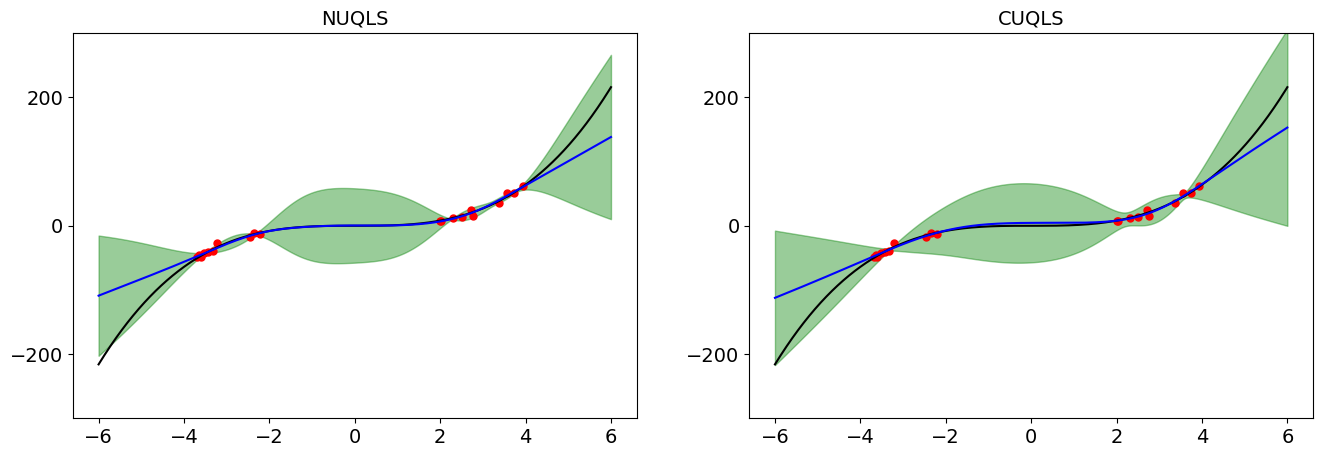

In [10]:
## Plot
def plot_torch(x):
    return x.detach().cpu().numpy().reshape(-1)

def plot_bayes_method(ax,mean,var,title,fs,ms,lw, legend_true=False):
    ax.plot(plot_torch(train_x),plot_torch(train_y),'ro',markersize=ms, label='Training data')
    ax.plot(plot_torch(test_x),plot_torch(test_y),'k',linewidth=lw, label='Target curve')
    ax.plot(plot_torch(test_x),plot_torch(mean),'b',linewidth=lw, label='Mean prediction')

    ci = torch.sqrt(var)*3
    y1, y2 = mean - ci, mean + ci

    ax.fill_between(plot_torch(test_x), plot_torch(y1), plot_torch(y2), color='g', alpha=.4, label='$3\sigma$')

    ax.set_title(title, fontsize=fs)
    ax.set_yticks(np.array((-200,0,200)))
    ax.set_ylim([-300,300])
    ax.tick_params(axis='both', which='major', labelsize=fs)

    if legend_true:
        ax.legend()

fs, ms, lw = 14, 5, 1.5

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 

f, ((ax1, ax2)) = plt.subplots(1,2)

f.set_figheight(5)
f.set_figwidth(16)
f.subplots_adjust(hspace=0.5)

# Plot NUQLS
plot_bayes_method(ax1,nuql_mu,nuql_var*1,'NUQLS',fs=fs, ms=ms, lw=lw)


# Plot CUQLs
plot_bayes_method(ax2,cuql_mu,cuql_var*25000,'CUQLS',fs=fs, ms=ms, lw=lw)

plt.savefig("UncertaintyComparisonUntrained.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
## DE - Heteroskedastic Variance
WIDTH = width

def to_np(x):
    return x.cpu().detach().numpy()

class EnsembleNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(1,WIDTH)
        self.relu = torch.nn.SiLU()
        self.linear_mu = torch.nn.Linear(WIDTH,1)
        self.linear_sig = torch.nn.Linear(WIDTH,1)

    def forward(self, x):
        x = self.relu(self.linear_1(x))
        mu = self.linear_mu(x)
        variance = self.linear_sig(x)
        variance = torch.nn.functional.softplus(variance) + 1e-6
        return mu, variance

class CustomNLL(torch.nn.Module):
    def __init__(self):
        super(CustomNLL, self).__init__()

    def forward(self, y, mean, var):
        
        loss = (0.5*torch.log(var) + 0.5*(y - mean).pow(2)/var).mean() + 1

        if np.any(np.isnan(to_np(loss))):
            print(torch.log(var))
            print((y - mean).pow(2)/var)
            raise ValueError('There is Nan in loss')
        
        return loss

S = 10
de_lr = 0.05
de_epochs = 2000
de_wd = 0

model_list = []
opt_list = []
sched_list = []

for i in range(S):
    model_list.append(EnsembleNetwork().to(device))
    model_list[i].apply(utils.training.weights_init_ff)
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = de_lr, weight_decay=de_wd))
    sched_list.append(torch.optim.lr_scheduler.PolynomialLR(opt_list[i], de_epochs, 0.5))

NLL = CustomNLL()

def train_heteroskedastic(X,y,net,loss,optim,sched):
    # Compute prediction error
    pred, var = net(X)
    loss = loss(y, pred, var)

    # Backpropagation
    loss.backward()

    optim.step()
    # sched.step()
    optim.zero_grad()

    return loss.item()

train_ensembles = True
if train_ensembles:
    for i in range(S):
        print("\nTraining model {}".format(i))
        for t in range(de_epochs):
            train_loss = train_heteroskedastic(train_x, train_y, model_list[i], NLL, opt_list[i], sched_list[i])
            if t % (de_epochs / 10) == 0:
                print("NLL loss = {}".format(train_loss))
                test_pred,test_var = model_list[i](train_x)
                mle_loss = mse_loss(test_pred,train_y)
                print("MSE loss = {}".format(mle_loss))
        print("Done!")

ensemble_het_mu = torch.empty((S,NUM_TEST_POINTS))
ensemble_het_var = torch.empty((S,NUM_TEST_POINTS))
for i in range(S):
    mu, var = model_list[i](test_x)
    ensemble_het_mu[i,:] = mu.reshape(1,-1)
    ensemble_het_var[i,:] = var.reshape(1,-1)
ensemble_het_mu_mean = torch.mean(ensemble_het_mu,dim=0)
ensemble_het_var_mean = torch.mean(ensemble_het_var + torch.square(ensemble_het_mu), dim=0) - torch.square(ensemble_het_mu_mean)


Training model 0
NLL loss = 5786.488303091173
MSE loss = 1102.10370890987
NLL loss = 6.041826569807389
MSE loss = 126.97445263061113
NLL loss = 5.432882841794442
MSE loss = 121.51612973758475
NLL loss = 4.942664948276802
MSE loss = 114.92197089416587
NLL loss = 4.571823176675101
MSE loss = 107.6311453093635
NLL loss = 4.283126118653706
MSE loss = 99.53194733448947
NLL loss = 4.046712615357148
MSE loss = 90.53790213129113
NLL loss = 3.846658422706276
MSE loss = 80.90963264379855
NLL loss = 3.678081843749162
MSE loss = 71.2765772333981
NLL loss = 3.5393117529073788
MSE loss = 62.11728846997109
Done!

Training model 1
NLL loss = 478.3752218639569
MSE loss = 1038.7475842003755
NLL loss = 4.501877621930415
MSE loss = 125.5826839300579
NLL loss = 3.458778835385213
MSE loss = 51.29529455907764
NLL loss = 3.031195084511654
MSE loss = 16.034661323063155
NLL loss = 2.9598186246241247
MSE loss = 14.779942377636479
NLL loss = 2.8856317684488224
MSE loss = 13.768843177366302
NLL loss = 2.802347339

In [ ]:
## SWAG
reload(swag)

swag_net = oneLayerMLP(width).to(device)
swag_net.apply(utils.training.weights_init_ff)

optimizer_MSE = torch.optim.Adam(swag_net.parameters(), lr = map_lr, weight_decay=map_wd)
scheduler_MSE = torch.optim.lr_scheduler.PolynomialLR(optimizer_MSE, map_epochs, 0.5)

for t in tqdm(range(map_epochs)):
    train_loss = train(train_x, train_y, swag_net, mse_loss, optimizer_MSE, scheduler_MSE)
    if t % (map_epochs / 10) == 0:
        print("Train loss = {}".format(train_loss))
print("Done!")

swag_method = swag.SWAG_R(swag_net,epochs = map_epochs, lr = map_lr, cov_mat = True,
                            max_num_models=10)
swag_method.train_swag(train_loader=toy_train_loader, weight_decay=0)

T = 1000
swag_pred_samples = torch.empty((T,NUM_TEST_POINTS),device='cpu')
for t in range(T):
    swag_method.sample(cov=True)
    swag_pred_samples[t,:] = swag_method(test_x).reshape(-1)
swag_pred = swag_pred_samples.mean(axis=0)
swag_var = swag_pred_samples.var(axis=0)

  8%|▊         | 808/10000 [00:00<00:02, 4025.16it/s]

Train loss = 1177.668567765551


 16%|█▋        | 1628/10000 [00:00<00:02, 4060.55it/s]

Train loss = 111.16576841934155


 24%|██▍       | 2434/10000 [00:00<00:01, 3980.00it/s]

Train loss = 70.30798109981842


 36%|███▋      | 3625/10000 [00:00<00:01, 3717.62it/s]

Train loss = 31.002113914626324


 44%|████▍     | 4434/10000 [00:01<00:01, 3828.80it/s]

Train loss = 16.16840262398382


 57%|█████▋    | 5657/10000 [00:01<00:01, 3990.51it/s]

Train loss = 12.949099362571639


 65%|██████▍   | 6453/10000 [00:01<00:00, 3929.33it/s]

Train loss = 12.217142603095017


 77%|███████▋  | 7661/10000 [00:01<00:00, 3971.88it/s]

Train loss = 11.778348860469462


 85%|████████▍ | 8482/10000 [00:02<00:00, 3984.41it/s]

Train loss = 11.51180474787553


 97%|█████████▋| 9691/10000 [00:02<00:00, 3943.03it/s]

Train loss = 11.378504365119216


100%|██████████| 10000/10000 [00:02<00:00, 3928.99it/s]


Done!


In [ ]:
## LLA
from posteriors.lla.likelihoods import GaussianLh
from posteriors.lla.laplace import Laplace

prior_prec = 0.028
lh = GaussianLh(sigma_noise=3)  # fixed to true noise

lap = Laplace(map_net, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(toy_train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(test_x, n_samples=1000)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(test_x, n_samples=1000)
        mu, var = samples.mean(dim=0), samples.var(dim=0)
    else:
        raise ValueError('unsupported model_type.')
    # mu = mu.detach().cpu().squeeze().numpy()
    # var = var.detach().cpu().squeeze().numpy()
    return mu.reshape(-1,1), var.reshape(-1,1)

# LLA
mu_glm_full, var_glm_full = get_pred_for('glm', 'full')



C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backpack\extensions\backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.oneLayerMLP'> although the module has parameters
  warnings.warn(


In [ ]:
## LA
prior_prec = 1
lh = GaussianLh(sigma_noise=3)  # fixed to true noise

lap = Laplace(map_net, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(toy_train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(test_x, n_samples=1000)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(test_x, n_samples=1000)
        mu, var = samples.mean(dim=0), samples.var(dim=0)
    else:
        raise ValueError('unsupported model_type.')
    # mu = mu.detach().cpu().squeeze().numpy()
    # var = var.detach().cpu().squeeze().numpy()
    return mu.reshape(-1,1), var.reshape(-1,1)

# LA
mu_bnn_full, var_bnn_full = get_pred_for('bnn', 'full')

In [ ]:
# VI
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from copy import deepcopy

const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 3.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 1,
}

vi_net = deepcopy(map_net)
    
dnn_to_bnn(vi_net, const_bnn_prior_parameters)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(vi_net.parameters(), 1e-3, weight_decay=0)

for _ in range(10000):
    output = vi_net(train_x)
    kl = get_kl_loss(vi_net)
    ce_loss = criterion(output, train_y)
    loss = ce_loss + kl

    loss.backward()
    optimizer.step()
    print(f"loss = {loss}")

vi_net.eval()
with torch.no_grad():
    output_mc = []
    for mc_run in range(1000):
        output = vi_net(test_x)
        output_mc.append(output)
    output = torch.stack(output_mc)  
    mu_vi = output.mean(0)
    var_vi = output.var(0)


loss = 1151.7337343330187
loss = 1144.5944499718087
loss = 1133.8927873747468
loss = 1138.815681012029
loss = 1131.9139328623394
loss = 1147.9636783128717
loss = 1139.0227573611626
loss = 1140.2052137245912
loss = 1140.175283705584
loss = 1141.479136514759
loss = 1137.1994416895418
loss = 1125.9362528706602
loss = 1137.4118583987704
loss = 1128.4715628810022
loss = 1136.9476243521133
loss = 1130.6677753701517
loss = 1131.8987657098482
loss = 1125.525629908681
loss = 1127.450420759418
loss = 1132.488822107226
loss = 1126.647439714844
loss = 1121.9573637567462
loss = 1128.3782039768312
loss = 1125.6595215804898
loss = 1131.863059672614
loss = 1114.2045641698824
loss = 1125.9109502749898
loss = 1123.3798998582613
loss = 1124.9169189373417
loss = 1119.7945206134202
loss = 1114.7739396775462
loss = 1121.4941517637974
loss = 1117.9743288156485
loss = 1117.4923886323616
loss = 1113.894044536628
loss = 1109.365490559558
loss = 1108.1078440321546
loss = 1120.535530690089
loss = 1117.15961094861

In [ ]:
## Plot
def plot_torch(x):
    return x.detach().cpu().numpy().reshape(-1)

def plot_bayes_method(ax,mean,var,title,fs,ms,lw, legend_true=False):
    ax.plot(plot_torch(train_x),plot_torch(train_y),'ro',markersize=ms, label='Training data')
    ax.plot(plot_torch(test_x),plot_torch(test_y),'k',linewidth=lw, label='Target curve')
    ax.plot(plot_torch(test_x),plot_torch(mean),'b',linewidth=lw, label='Mean prediction')

    ci = torch.sqrt(var)*3
    y1, y2 = mean - ci, mean + ci

    ax.fill_between(plot_torch(test_x), plot_torch(y1), plot_torch(y2), color='g', alpha=.4, label='$3\sigma$')

    ax.set_title(title, fontsize=fs)
    ax.set_yticks(np.array((-200,0,200)))
    ax.set_ylim([-300,300])
    ax.tick_params(axis='both', which='major', labelsize=fs)

    if legend_true:
        ax.legend()


In [ ]:
## Sampling LLA
from functorch import make_functional
from torch.func import vmap, jacrev

def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

fnet, params = make_functional(map_net)
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)
J = vmap(jacrev(fnet_single), (None, 0))(params, train_x.to(device))
J = [j.detach().flatten(1) for j in J]
J = torch.cat(J,dim=1).detach()
n, p = J.shape

theta_t = flatten(params)

S = 10
beta = 3
alpha = 0.01
lr = 2e-4
epochs = 10000
zeta = torch.empty((p,S), requires_grad=False)
zeta_exact = torch.empty((p,S), requires_grad=False)

print(f'---- parameter samples ----')
for s in range(S):
    Eps = torch.randn((n), requires_grad=False) * (beta)**(-0.5)
    theta0 = torch.randn((p), requires_grad=False) * (alpha)**(-0.5)

    # SGD
    # L = lambda z : 0.5 * beta * (J @ z - Eps).T @ (J @ z - Eps) + 0.5 * alpha * (z - theta0).T @ (z - theta0)
    L = lambda z : 0.5 * beta * (J @ z).T @ (J @ z) + 0.5 * alpha * (z - theta0 - beta/alpha * J.T @ Eps).T @ (z - theta0 - beta/alpha * J.T @ Eps)
    z = torch.nn.parameter.Parameter(theta0)
    optim = torch.optim.SGD([z],lr=lr, momentum=0.9)
    for i in range(epochs):
        loss = L(z)
        loss.backward()
        optim.step()
        optim.zero_grad()
    zeta[:,s] = z.detach()
    print(f'sample {s}, loss = {loss.item():.4}')

    # Exact
    with torch.no_grad():
        zeta_exact[:,s] = torch.linalg.solve(beta * J.T @ J + alpha * torch.eye(p), alpha * theta0 + beta * J.T @ Eps).detach()

    print(f'difference = {torch.linalg.norm(zeta[:,s] - zeta_exact[:,s])}')

J = vmap(jacrev(fnet_single), (None, 0))(params, test_x.to(device))
J = [j.detach().flatten(1) for j in J]
J = torch.cat(J,dim=1).detach()
n, p = J.shape

with torch.no_grad():
    pred_s = []
    f_nlin = map_net(test_x)
    for s in range(S):
        pred_lin = J @ (zeta[:,s] - theta_t) + f_nlin.squeeze(1)
        pred_s.append(pred_lin)

pred_lla = torch.stack(pred_s)

C:\Users\s4531973\AppData\Local\Temp\ipykernel_6080\549817684.py:9: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(map_net)


---- parameter samples ----
sample 0, loss = nan
difference = nan
sample 1, loss = nan
difference = nan


KeyboardInterrupt: 

In [ ]:
import posteriors.lla_s as lla_s
from importlib import reload
reload(lla_s)
pred_lla, res = lla_s.small_regression_parallel(net = map_net, train=train_data, test=test_data,
                            S = 100, epochs=10000, lr=5e-5, epochs_mode=1000, lr_mode=1e-2, 
                            alpha0=0.01, alpha_it=10, beta=3, exact=True, verbose=False)
print(res)

c:\Users\s4531973\Documents\PhD\Code\nuqls\posteriors\lla_s.py:145: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)
  0%|          | 0/10 [00:00<?, ?it/s]

Alpha = 0.01


 10%|█         | 1/10 [00:09<01:26,  9.58s/it]

Alpha = 0.054263831471989675


 20%|██        | 2/10 [00:19<01:17,  9.65s/it]

Alpha = 0.0346800045882637


 30%|███       | 3/10 [00:29<01:08,  9.79s/it]

Alpha = 0.027734803669884307


 40%|████      | 4/10 [00:38<00:58,  9.72s/it]

Alpha = 0.02531663922744384


 50%|█████     | 5/10 [00:48<00:48,  9.66s/it]

Alpha = 0.02637212126854692


 60%|██████    | 6/10 [00:58<00:38,  9.64s/it]

Alpha = 0.026713485431280343


 70%|███████   | 7/10 [01:07<00:28,  9.60s/it]

Alpha = 0.02606934052695944


 80%|████████  | 8/10 [01:17<00:19,  9.59s/it]

Alpha = 0.025059340601500654


 90%|█████████ | 9/10 [01:26<00:09,  9.67s/it]

Alpha = 0.023654786069534098


100%|██████████| 10/10 [01:36<00:00,  9.63s/it]


{'sample_loss': [], 'mode_loss': [12.859885473310593, 10.000870805072305, 8.67259610930435, 8.128719747229995, 7.899761080353609, 7.8407069630447825, 7.817990143133382, 7.785957211513346, 7.744282730153353, 7.692079974767471]}


In [ ]:
mu_glm_full.shape

torch.Size([10000, 1])

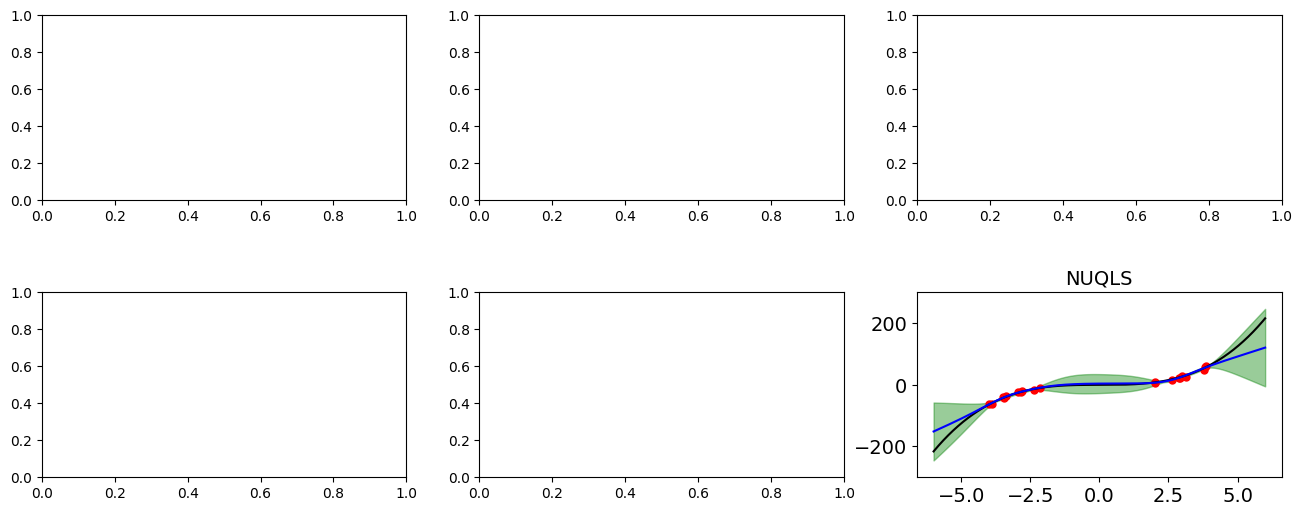

In [ ]:
fs, ms, lw = 14, 5, 1.5

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 

f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)

f.set_figheight(6)
f.set_figwidth(16)
f.subplots_adjust(hspace=0.5)

# Plot VI
plot_bayes_method(ax1,mu_vi,var_vi,'VI',fs=fs, ms=ms, lw=lw)

# Plot SWAG
plot_bayes_method(ax2,swag_pred,swag_var,'SWAG',fs=fs, ms=ms, lw=lw)

# LA
plot_bayes_method(ax3,mu_bnn_full,var_bnn_full,'LA',fs=fs, ms=ms, lw=lw)

# Plot LLA
plot_bayes_method(ax4,mu_glm_full,var_glm_full,'LLA',fs=fs, ms=ms, lw=lw)

# Plot DE
plot_bayes_method(ax5,ensemble_het_mu_mean,ensemble_het_var_mean,'DE',fs=fs, ms=ms, lw=lw)

## Plot NUQLs
plot_bayes_method(ax6,nuql_mu,nuql_var,'NUQLS',fs=fs, ms=ms, lw=lw)

# plt.savefig("UncertaintyComparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# BDE
from functorch import make_functional
from torch.func import vmap, jacrev

def l_layer_params(net):
    theta_star_k = []
    sd = net.state_dict()
    sdk = sd.keys()
    print(len(sdk))
    for i,p in enumerate(sdk):
        if i < len(sdk) - 2:
            theta_star_k.append(sd[p].flatten(0))
        else:
            theta_star_k.append(torch.zeros(sd[p].flatten(0).shape))
    theta_star_k = torch.cat(theta_star_k)
    return theta_star_k

def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

M = 10
learning_rate = 0.01
epochs = 10000
weight_decay = 0
sigma2 = std**2

model_list = []
opt_list = []
sched_list = []

loss = mse_loss
bde_preds = torch.empty((M,NUM_TEST_POINTS))

def train_bde(X,y,net,delta,theta_k,loss,Lambda,optim,sched):
    # Compute prediction error
    pred = net(X)

    # Add delta function to outputs
    pred = pred + delta

    # Calculate loss
    loss = loss(y, pred)

    # Regularisation
    theta_t = torch.nn.utils.parameters_to_vector(net.parameters())
    diff = theta_t - theta_k
    reg = diff @ (Lambda * diff)
    loss = 0.5 * loss + 0.5 * reg

    # Backpropagation
    loss.backward()

    optim.step()
    if sched is not None:
        sched.step()
    optim.zero_grad()

    return loss.item()

def bde_weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.normal_(m.bias,mean=0,std=1)

for i in range(M):
    bde_model1 = oneLayerMLP(width).to(device)
    bde_model1.apply(bde_weights_init)
    opt = torch.optim.Adam(bde_model1.parameters(), lr = map_lr, weight_decay=map_wd)
    sched = torch.optim.lr_scheduler.PolynomialLR(opt, map_epochs, 0.5)

    ## Find theta~
    bde_model2 = oneLayerMLP(width).to(device)
    bde_model2.apply(utils.training.weights_init_ff) 
    theta_star_k = l_layer_params(bde_model2)

    ## Create delta functions
    fnet, params = make_functional(bde_model1)
    def jacobian(x):
        def fnet_single(params, x):
            return fnet(params, x.unsqueeze(0)).squeeze(0)
        J = vmap(jacrev(fnet_single), (None, 0))(params, x.to(device))
        J = [j.detach().flatten(1) for j in J]
        J = torch.cat(J,dim=1).detach()
        return J
    delta = lambda x : jacobian(x) @ theta_star_k
    train_delta = delta(train_x)

    ## Save theta_k
    theta_k = torch.nn.utils.parameters_to_vector(bde_model1.parameters()).detach().clone()

    ## Create Mahalanobis matrix
    Lambda = 1 / sigma2

    ## Train ensemble member
    print("\nTraining model {}".format(i))
    for t in tqdm(range(map_epochs)):
        train_loss = train_bde(train_x, train_y, bde_model1, train_delta, theta_k, mse_loss, Lambda, opt, sched)
        if t % (epochs / 10) == 0:
            print("train loss = {:.4f}".format(train_loss))
    print("Done!")

    # Get predictions
    bde_pred = bde_model1(test_x).reshape(-1) + delta(test_x).reshape(-1)
    bde_preds[i,:] = bde_pred

bde_mean = torch.mean(bde_preds,dim=0)
bde_var = torch.var(bde_preds,dim=0)  + std**2

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


4

Training model 0


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20, 20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▎         | 250/10000 [00:00<00:03, 2483.89it/s]

train loss = 533.4134


 13%|█▎        | 1290/10000 [00:00<00:03, 2578.00it/s]

train loss = 55.5286


 23%|██▎       | 2336/10000 [00:00<00:02, 2596.29it/s]

train loss = 35.5443


 34%|███▎      | 3366/10000 [00:01<00:02, 2542.99it/s]

train loss = 23.0565


 44%|████▍     | 4389/10000 [00:01<00:02, 2477.20it/s]

train loss = 16.8637


 52%|█████▏    | 5169/10000 [00:02<00:01, 2558.18it/s]

train loss = 15.1949


 65%|██████▌   | 6525/10000 [00:02<00:01, 2613.51it/s]

train loss = 14.9941


 73%|███████▎  | 7309/10000 [00:02<00:01, 2601.46it/s]

train loss = 14.8601


 84%|████████▎ | 8360/10000 [00:03<00:00, 2602.85it/s]

train loss = 14.7600


 94%|█████████▍| 9408/10000 [00:03<00:00, 2608.92it/s]

train loss = 14.6909


100%|██████████| 10000/10000 [00:03<00:00, 2566.58it/s]


Done!
4

Training model 1


  3%|▎         | 258/10000 [00:00<00:03, 2575.42it/s]

train loss = 556.4361


 16%|█▌        | 1562/10000 [00:00<00:03, 2596.66it/s]

train loss = 59.5436


 24%|██▎       | 2357/10000 [00:00<00:02, 2613.65it/s]

train loss = 39.3076


 34%|███▍      | 3421/10000 [00:01<00:02, 2634.68it/s]

train loss = 22.7383


 45%|████▍     | 4479/10000 [00:01<00:02, 2634.72it/s]

train loss = 17.2138


 55%|█████▌    | 5537/10000 [00:02<00:01, 2618.45it/s]

train loss = 16.2811


 63%|██████▎   | 6335/10000 [00:02<00:01, 2642.65it/s]

train loss = 15.9727


 74%|███████▍  | 7413/10000 [00:02<00:00, 2641.06it/s]

train loss = 15.7726


 85%|████████▍ | 8475/10000 [00:03<00:00, 2625.49it/s]

train loss = 15.6227


 93%|█████████▎| 9268/10000 [00:03<00:00, 2609.43it/s]

train loss = 15.5128


100%|██████████| 10000/10000 [00:03<00:00, 2613.58it/s]


Done!
4

Training model 2


  2%|▏         | 222/10000 [00:00<00:04, 2218.95it/s]

train loss = 623.2390


 15%|█▌        | 1549/10000 [00:00<00:03, 2601.48it/s]

train loss = 59.4386


 23%|██▎       | 2344/10000 [00:00<00:02, 2623.46it/s]

train loss = 45.3242


 34%|███▍      | 3411/10000 [00:01<00:02, 2590.32it/s]

train loss = 31.3343


 45%|████▍     | 4473/10000 [00:01<00:02, 2635.38it/s]

train loss = 19.4706


 55%|█████▌    | 5545/10000 [00:02<00:01, 2644.01it/s]

train loss = 16.6916


 63%|██████▎   | 6341/10000 [00:02<00:01, 2630.04it/s]

train loss = 16.3149


 74%|███████▍  | 7393/10000 [00:02<00:00, 2613.17it/s]

train loss = 16.1621


 85%|████████▍ | 8457/10000 [00:03<00:00, 2637.47it/s]

train loss = 16.0703


 95%|█████████▌| 9518/10000 [00:03<00:00, 2603.56it/s]

train loss = 16.0081


100%|██████████| 10000/10000 [00:03<00:00, 2601.71it/s]


Done!
4

Training model 3


  3%|▎         | 259/10000 [00:00<00:03, 2569.94it/s]

train loss = 568.8545


 13%|█▎        | 1327/10000 [00:00<00:03, 2651.90it/s]

train loss = 53.8198


 24%|██▍       | 2384/10000 [00:00<00:02, 2610.94it/s]

train loss = 33.4081


 34%|███▍      | 3436/10000 [00:01<00:02, 2603.63it/s]

train loss = 21.2292


 45%|████▍     | 4492/10000 [00:01<00:02, 2613.85it/s]

train loss = 15.9161


 53%|█████▎    | 5280/10000 [00:02<00:01, 2606.10it/s]

train loss = 14.9293


 64%|██████▎   | 6355/10000 [00:02<00:01, 2638.51it/s]

train loss = 14.7328


 74%|███████▍  | 7415/10000 [00:02<00:00, 2589.66it/s]

train loss = 14.6258


 85%|████████▍ | 8471/10000 [00:03<00:00, 2614.08it/s]

train loss = 14.5520


 95%|█████████▌| 9528/10000 [00:03<00:00, 2618.86it/s]

train loss = 14.5010


100%|██████████| 10000/10000 [00:03<00:00, 2598.76it/s]


Done!
4

Training model 4


  3%|▎         | 260/10000 [00:00<00:03, 2599.61it/s]

train loss = 560.0854


 13%|█▎        | 1321/10000 [00:00<00:03, 2631.59it/s]

train loss = 54.2182


 24%|██▍       | 2378/10000 [00:00<00:02, 2621.33it/s]

train loss = 39.7677


 34%|███▍      | 3436/10000 [00:01<00:02, 2630.05it/s]

train loss = 26.0075


 42%|████▏     | 4225/10000 [00:01<00:02, 2575.13it/s]

train loss = 17.6983


 55%|█████▌    | 5541/10000 [00:02<00:01, 2582.62it/s]

train loss = 15.3703


 63%|██████▎   | 6337/10000 [00:02<00:01, 2630.61it/s]

train loss = 15.0556


 74%|███████▍  | 7402/10000 [00:02<00:00, 2635.93it/s]

train loss = 14.9163


 85%|████████▍ | 8462/10000 [00:03<00:00, 2625.14it/s]

train loss = 14.8114


 93%|█████████▎| 9256/10000 [00:03<00:00, 2623.68it/s]

train loss = 14.7476


100%|██████████| 10000/10000 [00:03<00:00, 2601.53it/s]


Done!
4

Training model 5


  3%|▎         | 262/10000 [00:00<00:03, 2595.57it/s]

train loss = 551.2188


 13%|█▎        | 1322/10000 [00:00<00:03, 2632.07it/s]

train loss = 53.5562


 24%|██▎       | 2374/10000 [00:00<00:02, 2598.65it/s]

train loss = 39.2804


 34%|███▍      | 3418/10000 [00:01<00:02, 2591.67it/s]

train loss = 28.5493


 45%|████▍     | 4477/10000 [00:01<00:02, 2615.50it/s]

train loss = 20.9008


 53%|█████▎    | 5266/10000 [00:02<00:01, 2618.11it/s]

train loss = 16.6769


 63%|██████▎   | 6322/10000 [00:02<00:01, 2622.88it/s]

train loss = 15.7337


 74%|███████▍  | 7377/10000 [00:02<00:01, 2599.80it/s]

train loss = 15.5237


 84%|████████▍ | 8436/10000 [00:03<00:00, 2624.29it/s]

train loss = 15.4159


 92%|█████████▏| 9225/10000 [00:03<00:00, 2604.31it/s]

train loss = 15.3436


100%|██████████| 10000/10000 [00:03<00:00, 2597.40it/s]


Done!
4

Training model 6


  3%|▎         | 255/10000 [00:00<00:03, 2538.71it/s]

train loss = 573.2790


 15%|█▌        | 1517/10000 [00:00<00:03, 2448.60it/s]

train loss = 55.3056


 22%|██▏       | 2247/10000 [00:00<00:03, 2264.49it/s]

train loss = 39.1578


 35%|███▍      | 3466/10000 [00:01<00:02, 2369.57it/s]

train loss = 25.7335


 42%|████▏     | 4190/10000 [00:01<00:02, 2360.58it/s]

train loss = 18.5271


 54%|█████▍    | 5402/10000 [00:02<00:02, 2293.55it/s]

train loss = 16.2570


 64%|██████▍   | 6398/10000 [00:02<00:01, 2376.66it/s]

train loss = 15.9061


 74%|███████▎  | 7360/10000 [00:03<00:01, 2256.32it/s]

train loss = 15.7679


 83%|████████▎ | 8270/10000 [00:03<00:00, 2221.97it/s]

train loss = 15.6672


 94%|█████████▍| 9446/10000 [00:04<00:00, 2312.28it/s]

train loss = 15.5901


100%|██████████| 10000/10000 [00:04<00:00, 2324.71it/s]


Done!
4

Training model 7


  3%|▎         | 254/10000 [00:00<00:03, 2527.60it/s]

train loss = 554.7310


 13%|█▎        | 1265/10000 [00:00<00:03, 2449.62it/s]

train loss = 56.3163


 23%|██▎       | 2285/10000 [00:00<00:03, 2532.53it/s]

train loss = 37.1089


 33%|███▎      | 3296/10000 [00:01<00:02, 2462.65it/s]

train loss = 23.9950


 43%|████▎     | 4267/10000 [00:01<00:02, 2261.30it/s]

train loss = 17.1496


 54%|█████▍    | 5390/10000 [00:02<00:02, 2097.19it/s]

train loss = 15.5918


 63%|██████▎   | 6265/10000 [00:02<00:01, 1928.87it/s]

train loss = 15.3779


 74%|███████▍  | 7435/10000 [00:03<00:01, 2268.66it/s]

train loss = 15.2433


 84%|████████▍ | 8402/10000 [00:03<00:00, 2311.11it/s]

train loss = 15.0423


 94%|█████████▎| 9371/10000 [00:04<00:00, 2396.80it/s]

train loss = 14.9134


100%|██████████| 10000/10000 [00:04<00:00, 2279.30it/s]


Done!
4

Training model 8


  3%|▎         | 253/10000 [00:00<00:03, 2508.20it/s]

train loss = 548.5407


 13%|█▎        | 1276/10000 [00:00<00:03, 2533.36it/s]

train loss = 62.1805


 23%|██▎       | 2292/10000 [00:00<00:03, 2534.92it/s]

train loss = 46.2824


 33%|███▎      | 3327/10000 [00:01<00:02, 2455.62it/s]

train loss = 28.6373


 43%|████▎     | 4320/10000 [00:01<00:02, 2456.84it/s]

train loss = 19.0213


 53%|█████▎    | 5309/10000 [00:02<00:02, 2289.06it/s]

train loss = 16.8790


 63%|██████▎   | 6274/10000 [00:02<00:01, 2338.00it/s]

train loss = 16.4495


 73%|███████▎  | 7283/10000 [00:03<00:01, 2441.40it/s]

train loss = 16.1145


 83%|████████▎ | 8278/10000 [00:03<00:00, 2444.19it/s]

train loss = 15.8996


 93%|█████████▎| 9278/10000 [00:03<00:00, 2384.32it/s]

train loss = 15.7479


100%|██████████| 10000/10000 [00:04<00:00, 2408.56it/s]


Done!
4

Training model 9


  2%|▏         | 248/10000 [00:00<00:03, 2463.95it/s]

train loss = 553.4981


 13%|█▎        | 1260/10000 [00:00<00:03, 2450.67it/s]

train loss = 56.8001


 25%|██▌       | 2534/10000 [00:01<00:02, 2492.82it/s]

train loss = 39.9455


 33%|███▎      | 3290/10000 [00:01<00:02, 2475.10it/s]

train loss = 28.4070


 43%|████▎     | 4331/10000 [00:01<00:02, 2526.88it/s]

train loss = 18.8767


 54%|█████▍    | 5388/10000 [00:02<00:01, 2552.64it/s]

train loss = 16.1767


 64%|██████▍   | 6413/10000 [00:02<00:01, 2553.54it/s]

train loss = 15.7268


 74%|███████▍  | 7441/10000 [00:02<00:01, 2495.57it/s]

train loss = 15.4751


 85%|████████▍ | 8477/10000 [00:03<00:00, 2530.08it/s]

train loss = 15.3081


 92%|█████████▏| 9241/10000 [00:03<00:00, 2510.81it/s]

train loss = 15.1996


100%|██████████| 10000/10000 [00:04<00:00, 2485.28it/s]

Done!


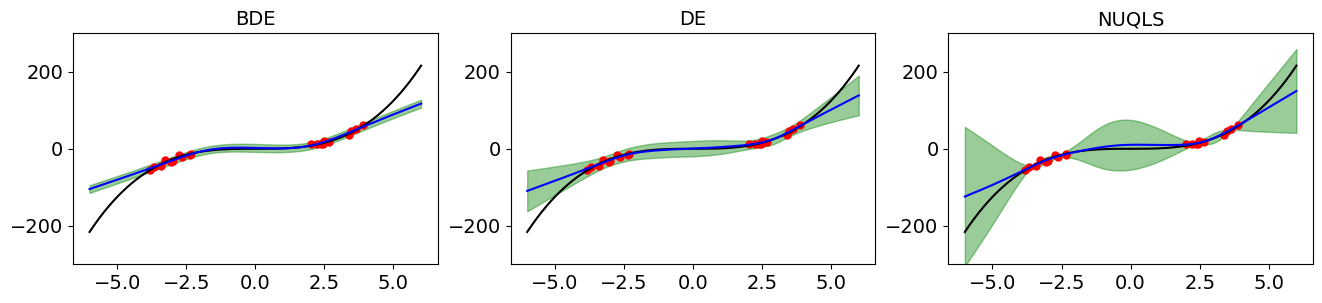

In [ ]:
fs, ms, lw = 14, 5, 1.5

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 

f, (ax1,ax2,ax3) = plt.subplots(1,3)

f.set_figheight(3)
f.set_figwidth(16)
f.subplots_adjust(hspace=0.5)

## Plot BDE
plot_bayes_method(ax1,bde_mean,bde_var,'BDE',fs=fs, ms=ms, lw=lw)

## Plot DE
plot_bayes_method(ax2,ensemble_het_mu_mean,ensemble_het_var_mean,'DE',fs=fs, ms=ms, lw=lw)

## Plot NUQLs
plot_bayes_method(ax3,nuql_mu,nuql_var,'NUQLS',fs=fs, ms=ms, lw=lw)

plt.savefig("UncertaintyComparison_bde.pdf", format="pdf", bbox_inches="tight")
plt.show()